# 板块分类IC
1. 读取本地因子数据
2. 计算factor_data
3. 计算板块IC
4. 筛选与处理板块数据

## 1_读取本地因子数据
读取本地数据并转换格式
1. mask
2. group
3. factor
4. price

In [1]:
from jaqs.data.dataapi import DataApi
from jaqs.data import DataView
from jaqs.research import SignalDigger
import numpy as np
from datetime import datetime
import pandas as pd
from datetime import timedelta
import warnings

warnings.filterwarnings("ignore")

dataview_folder = '../../JAQS_Data/hs300'
dv = DataView()
dv.load_dataview(dataview_folder)

C:\ProgramData\Anaconda3\envs\qtc\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Dataview loaded successfully.


In [2]:
def change_columns_index(signal):
    new_names = {}
    for c in signal.columns:
        if c.endswith('SZ'):
            new_names[c] = c.replace('SZ', 'XSHE')
        elif c.endswith('SH'):
            new_names[c] = c.replace('SH', 'XSHG')
    signal = signal.rename_axis(new_names, axis=1)
    signal.index = pd.Index(map(lambda x: datetime.strptime(str(x),"%Y%m%d") , signal.index))
    return signal

In [3]:
mask = dv.get_ts('mask_fundamental')

In [4]:
group = change_columns_index(dv.get_ts('group'))

In [5]:
PB_Data = change_columns_index(dv.get_ts('pb').shift(1, axis=0)[mask==0])

In [6]:
prices = change_columns_index(dv.get_ts('close_adj'))

## 2_计算factor_data
alphalens.utils.get_clean_factor_and_forward_returns()

In [7]:
import alphalens as al

def get_factor_data(factor, prices, group):
    factor_data = al.utils.get_clean_factor_and_forward_returns(factor.stack(),
                                         prices,
                                         groupby=group.stack(),
                                         by_group=False,
                                         quantiles=5,
                                         bins=None,
                                         periods=(1, 5, 10),
                                         filter_zscore=20,
                                         groupby_labels=None)
    return factor_data

In [8]:
factor_data = get_factor_data(PB_Data, prices, group)

Dropped 4.4% entries from factor data (4.4% after in forward returns computation and 0.0% in binning phase). Set max_loss=0 to see potentially suppressed Exceptions.


In [9]:
print(factor_data.head())

                               1         5        10  factor  \
date       asset                                               
2012-01-05 000001.XSHE -0.002599  0.025341  0.025341  1.1142   
           000002.XSHE -0.012414  0.037241  0.074483  1.7186   
           000008.XSHE  0.006299  0.111811  0.034646  6.6091   
           000009.XSHE  0.059748  0.322851  0.363732  4.1941   
           000012.XSHE  0.008537  0.190244  0.234146  2.6377   

                                            group  factor_quantile  
date       asset                                                    
2012-01-05 000001.XSHE                    Finance                1  
           000002.XSHE                Real_Estate                2  
           000008.XSHE  Accommodation_Restaurants                5  
           000009.XSHE        Synthesise_Industry                4  
           000012.XSHE              Manufacturing                3  


## 3_计算板块IC
1. 全量数据板块IC
2. 过去一年板块IC(避免未来数据)

alphalens.performance.mean_information_coefficient()

In [10]:
import matplotlib.pyplot as plt

def get_ic_performance(factor_data):
    ic_by_sector = al.performance.mean_information_coefficient(factor_data, by_group=True)
    al.plotting.plot_ic_by_group(ic_by_sector)
    plt.show()
    return ic_by_sector

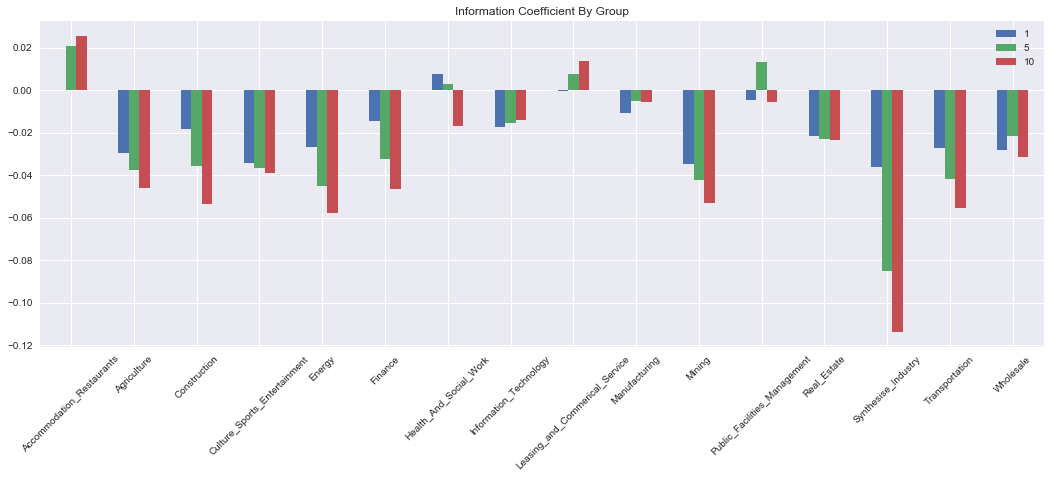

In [11]:
factor_ic = get_ic_performance(factor_data)

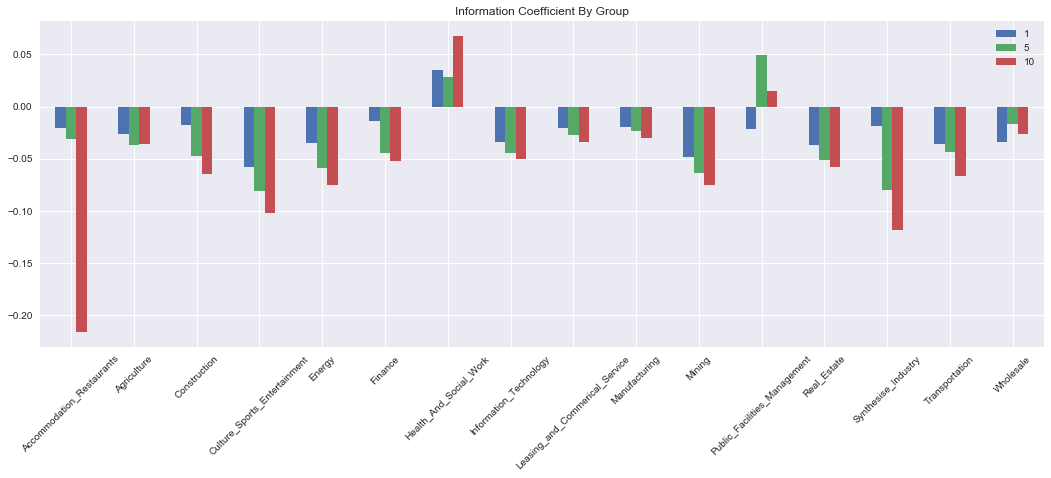

In [12]:
factor_ic_sample = get_ic_performance(factor_data.loc['20150106':'20161230'])

In [13]:
print(factor_ic_sample)

                                      1         5         10
group                                                       
Accommodation_Restaurants      -0.020833 -0.030928 -0.216495
Agriculture                    -0.026206 -0.036600 -0.035583
Construction                   -0.017382 -0.047633 -0.064339
Culture_Sports_Entertainment   -0.057878 -0.080522 -0.101539
Energy                         -0.034706 -0.058490 -0.075038
Finance                        -0.013298 -0.044118 -0.051847
Health_And_Social_Work          0.035052  0.028807  0.067762
Information_Technology         -0.033438 -0.044260 -0.049984
Leasing_and_Commerical_Service -0.020507 -0.026818 -0.033660
Manufacturing                  -0.019122 -0.023002 -0.029964
Mining                         -0.048074 -0.063702 -0.075116
Public_Facilities_Management   -0.021703  0.049277  0.014612
Real_Estate                    -0.037063 -0.050743 -0.057497
Synthesise_Industry            -0.018480 -0.080082 -0.118070
Transportation          

In [14]:
print(factor_ic_sample[10].index[factor_ic_sample[10]<-0.1])

Index(['Accommodation_Restaurants', 'Culture_Sports_Entertainment',
       'Synthesise_Industry'],
      dtype='object', name='group')


## 4_筛选与处理板块数据

目的： 根据过去的IC选取板块，再从选中的板块中根据因子值排序选取股票，最后用因子值计算权重。

In [15]:
class get_stock_df():
    def __init__(self, factor_data, factor_ic,period=10, n=10, ic=0.02):
        '''
        period: 持有周期
        n: 选取股票数量
        ic: ic的阈值
        '''
        self.factor_data = factor_data
        self.factor = factor_data.factor.unstack()
        self.factor_ic = factor_ic
        self.n = n
        self.ic= ic
        self.period = period

    def get_largest(self, backtest):
        largest_list = []
        for time_index, value in backtest.iterrows():
            largest_list.append(value.nlargest(self.n).to_dict())
        df = pd.DataFrame(largest_list, index = backtest.index)
        df.index = list(map(lambda idx: idx+timedelta(hours=15), df.index))
        return df

    def get_smallest(self, backtest):
        smallest_list = []
        for time_index, value in backtest.iterrows():
            smallest_list.append(value.nsmallest(self.n).to_dict())
        df = pd.DataFrame(smallest_list, index=backtest.index)
        df.index = list(map(lambda idx: idx+timedelta(hours=15), df.index))
        return df

    def get_group(self, sequence, ic_targets):
        for value in sequence:
            if value in ic_targets:
                yield True
            else:
                yield False

    def get_largest_stocks(self):
        high_ic = self.factor_ic[self.period][self.factor_ic[self.period]>self.ic].index
        group = list(self.get_group(self.factor_data.group.values, high_ic))
        backtest = self.factor_data.factor[group].unstack()
        largest = self.get_largest(backtest)
        weight_list = []
        for time_index, weight in largest.iterrows():
            weight[weight<0]=0
            weiht_result = (weight/weight.sum())
            weight_list.append(weiht_result.to_dict())
        stock_df = pd.DataFrame(weight_list, index=largest.index)
        return stock_df

    def get_smallest_stocks(self):
        low_ic = self.factor_ic[self.period][self.factor_ic[self.period]<-self.ic].index
        group = list(self.get_group(self.factor_data.group.values, low_ic))
        backtest = self.factor_data.factor[group].unstack()
        smallest = self.get_smallest(backtest)
        weight_list = []
        for time_index, weight in smallest.iterrows():
            weight[weight<0]=0
            weiht_result = (weight/weight.sum())
            weight_list.append(weiht_result.to_dict())
        stock_df = pd.DataFrame(weight_list, index=smallest.index)
        return stock_df

In [16]:
small_stock = get_stock_df(factor_data, factor_ic_sample, period=10, n=5, ic=0.05).get_smallest_stocks()

In [17]:
stock_df = small_stock.loc['20170104':]

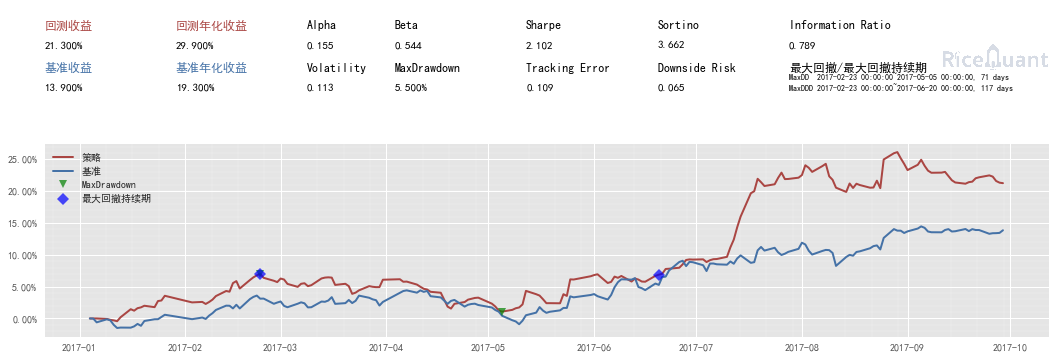

{'sys_analyser': {'benchmark_portfolio':                cash  market_value  static_unit_net_value  total_value  \
  date                                                                    
  2017-01-04  2980.24     997019.76                  1.000   1000000.00   
  2017-01-05  2980.24     996865.84                  1.000    999846.08   
  2017-01-06  2980.24     990910.32                  1.000    993890.56   
  2017-01-09  2980.24     995714.40                  0.994    998694.64   
  2017-01-10  2980.24     994047.92                  0.999    997028.16   
  2017-01-11  2980.24     987012.00                  0.997    989992.24   
  2017-01-12  2980.24     982015.52                  0.990    984995.76   
  2017-01-13  2980.24     982693.36                  0.985    985673.60   
  2017-01-16  2980.24     982557.20                  0.986    985537.44   
  2017-01-17  2980.24     984602.56                  0.986    987582.80   
  2017-01-18  2980.24     988453.52                  0.988   

In [18]:
import numpy as np
import talib as ta
import pandas as pd
import rqalpha
from rqalpha.api import *

#读取文件位置
def init(context):
    context.codes = stock_df
    context.hs300 = '000300.XSHG'
    context.stocks = {}
#     scheduler.run_daily(find_pool)
    scheduler.run_weekly(find_pool, tradingday=1)

def find_pool(context, bar_dict):
    codes = context.codes.loc[context.now].dropna()
    if codes is not None:
        context.stocks = codes
    else:
        context.stocks = {}

def handle_bar(context, bar_dict):
    buy(context, bar_dict)
    
    
def buy(context, bar_dict):
    pool = context.stocks
    if pool is not None:
        for stocks in context.portfolio.positions:
            if stocks not in pool:
                order_target_percent(stocks, 0)
        for codes, target in pool.items():
            try:
                order_target_percent(codes, target)
            except ValueError as ve:
                continue

config = {
  "base": {
    "start_date": "2017-01-04",
    "end_date": "2017-12-10",
    "accounts": {'stock':1000000},
    "benchmark": "000300.XSHG"
  },
  "extra": {
    "log_level": "error",
  },
  "mod": {
    "sys_analyser": {
      "enabled": True,
      "plot": True
    }
  }
}

rqalpha.run_func(init=init, handle_bar=handle_bar, config=config)